# 3D Dust map

3D Dust map

Lallement et al. (2019)

In [1]:
# import required libraries
import os
import sys
import glob
import pickle

import copy as cp
import itertools as it

import seaborn as sns
import numpy   as np
import pandas  as pd

from astropy.io import fits
import scipy
import pickle

import matplotlib.pyplot as plt
import matplotlib        as mpl

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker  import AutoMinorLocator    

import h5py as h5
import healpy as hp

from numba import jit, njit

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube

In [3]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

# Paths

In [4]:
base  = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC   = os.path.join(askap, 'LMC')

LMC_plots = os.path.join(LMC, 'plots')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')

data_path = os.path.join(askap, 'data')

LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')
GASS_data_path = os.path.join(LMC_data_path, 'GASS')


dust_data_path = os.path.join(data_path, 'dust')
lallement19_data_path = os.path.join(dust_data_path, 'lallement19')
lallement19_data_path

'/Users/kiemhiep/ANU/ASKAP/data/dust/lallement19'

In [5]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))

gaussfit_dir = os.path.join( parent_dir, 'gaussfit')
sys.path.append(parent_dir)
module_dir = os.path.join( parent_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

script_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/dust
parent_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit
gaussfit_dir:  /Users/kiemhiep/opt/anaconda3/envs/gfit/gaussfit


'/Users/kiemhiep/opt/anaconda3/envs/gfit/dust'

In [6]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [7]:
# script_dir = os.path.dirname(os.path.realpath('__file__'))
# parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
# grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
# module_dir = os.path.join(script_dir, 'gausspy', 'gausspy')
sys.path.append(parent_dir)

# import gp as gp
from mpfit import mpfit

# FCN

In [8]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    
    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

# GASS HI map

In [23]:
# Moment Maps
moment0_file = os.path.join(GASS_data_path, 'moment0_LMC_fg.fits')
m0, hi_hdr = fits.getdata(moment0_file, header=True)
print('Image shape: ', m0.shape)

# Parse the WCS keywords in the primary HDU
hi_wcs = WCS(hi_hdr)

Image shape:  (288, 464)


In [12]:
## RADEC J2000 (deg) to Galactic l/b (deg)
# HI_GLON, HI_GLAT = np.meshgrid(xaxis, yaxis, indexing='ij')
# c           = SkyCoord(ra = HI_GLON*u.degree, dec = HI_GLAT*u.degree)
# gal         = c.galactic
# gl          = gal.l.degree
# gb          = gal.b.degree

In [24]:
hi_wcs.__dict__

{'_init_kwargs': {'keysel': None, 'colsel': None},
 'naxis': 2,
 '_naxis': [464, 288],
 '_pixel_bounds': None}

In [25]:
nhi_thin = m0*0.018224

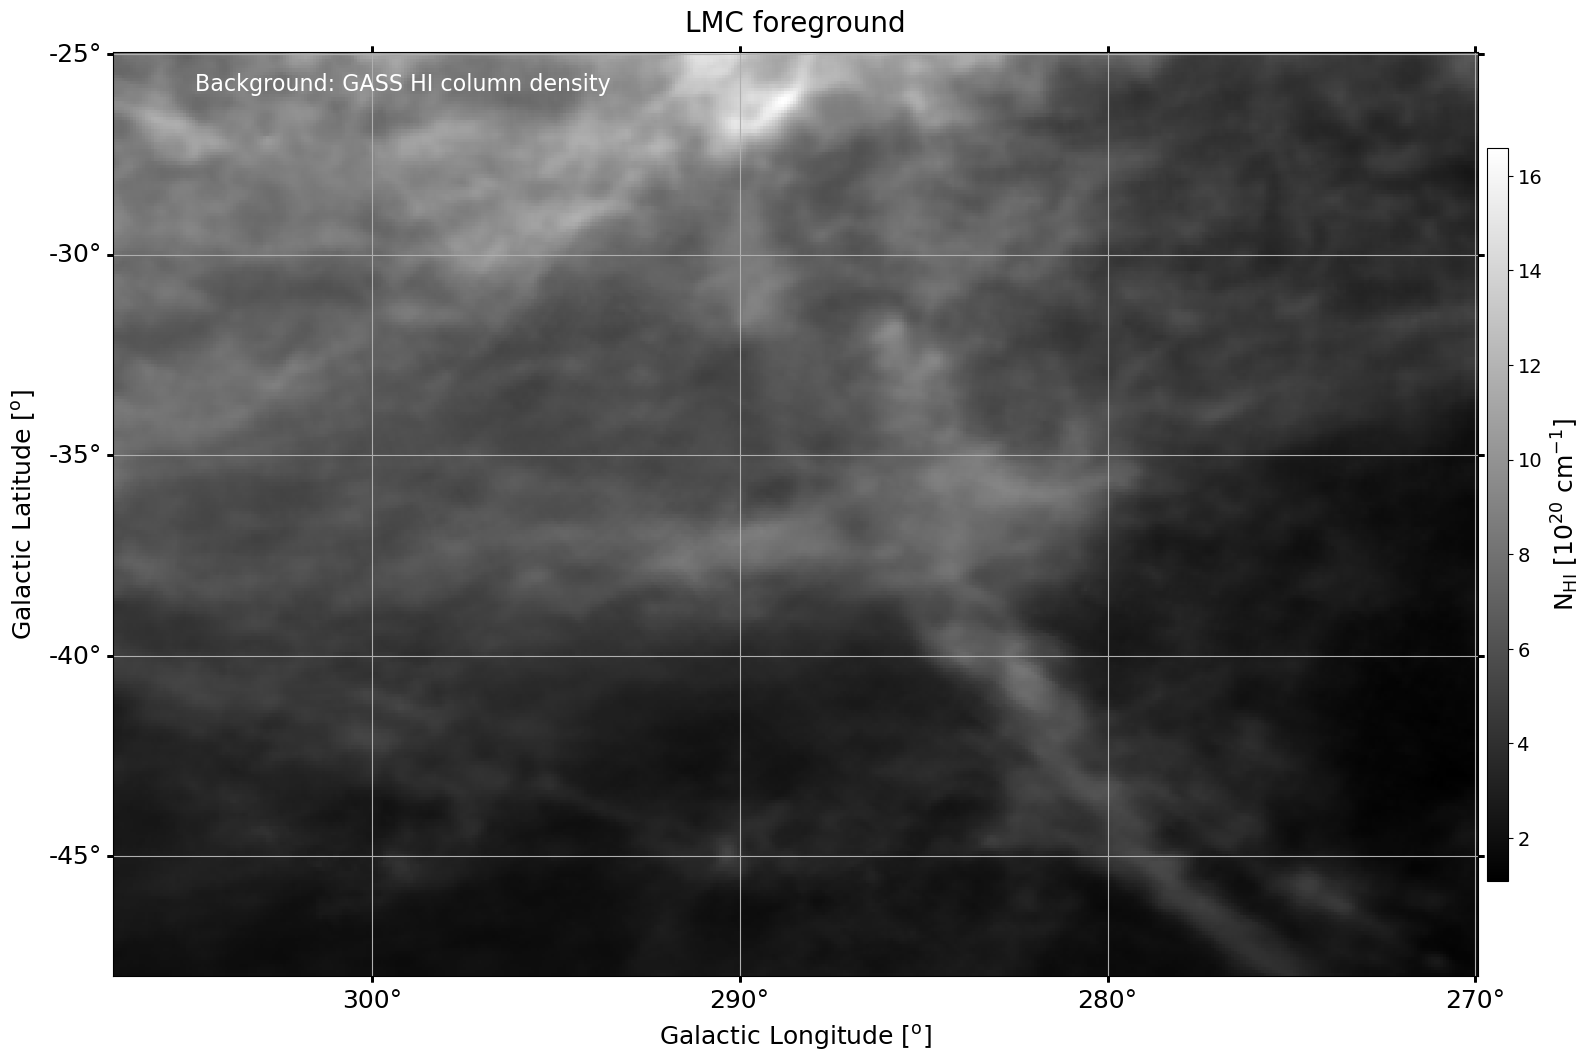

In [27]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection = hi_wcs)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = nhi_thin.min()
maxval = nhi_thin.max()

im = ax.pcolormesh(nhi_thin, cmap='gray', vmin=minval, vmax=maxval)
# im = ax.pcolormesh(HI_GLON, HI_GLAT, nhi_thin, cmap='gray', vmin=minval, vmax=maxval)

ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
# ax.invert_xaxis()


ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{N_{HI}}$ [10$^{20}$ cm$^{-1}$]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"LMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

Opticall-thin N(HI) mean: 5.090000152587891
Opticall-thin N(HI) median: 4.71999979019165


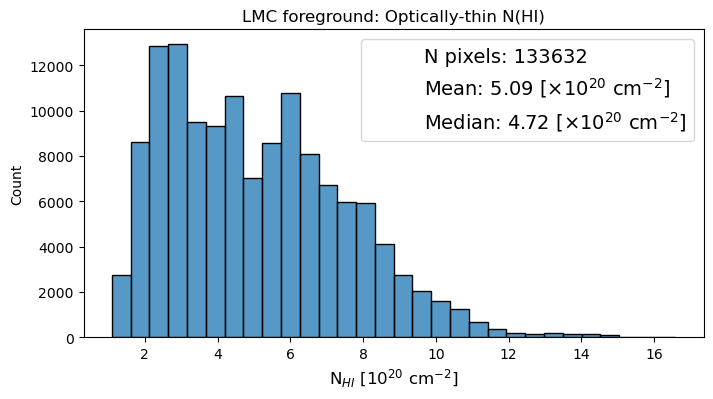

In [28]:
nhi_thin_LMC_fg = nhi_thin.flatten()
N_pixels = m0.shape[0] * m0.shape[1]
xmean = np.round(np.mean(nhi_thin_LMC_fg), 2)
xmedian = np.round(np.median(nhi_thin_LMC_fg), 2)

print(f"Opticall-thin N(HI) mean: {xmean}")
print(f"Opticall-thin N(HI) median: {xmedian}")

# Optically-thin HI column density
plt.figure(figsize=(8, 4))

sns.histplot(data=nhi_thin_LMC_fg, bins=30, kde=False)

ploti, = plt.plot([], [], '', label=f"N pixels: {N_pixels}")
ploti.set_visible(False)
ploti, = plt.plot([], [], '', label=r"Mean: 5.09 [$\times$10$^{20}$ cm$^{-2}$]")
ploti.set_visible(False)
ploti, = plt.plot([], [], '', label=r"Median: 4.72 [$\times$10$^{20}$ cm$^{-2}$]")
ploti.set_visible(False)
    
# for labeli,vali in zip(labels, stats_values):
#     ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
#     ploti.set_visible(False)

plt.title(f'LMC foreground: Optically-thin N(HI)')
plt.xlabel(r'N$_{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

# Read GD results

In [29]:
bridge_fields = [38466, 38215, 38758, 38509]

In [30]:
csv_filename = os.path.join(gfit_path, "GD_result_table.csv")
LMC_fg_GD_res_df = pd.read_csv(csv_filename)
print(f"df shape: {LMC_fg_GD_res_df.shape}")
nrows, ncols = LMC_fg_GD_res_df.shape
LMC_fg_GD_res_df.head()

df shape: (483, 35)


,comp_name,sbid,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,...,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin
0,J004222-754838,38215,10.593081,-75.810688,303.671291,-41.304546,1,A,305.821991,0.001330,...,3.410674,0.006363,0.236043,0.008039,0.980426,0.007816,4.465300,0.035404,4.503674,0.006460
1,J005321-770019,38215,13.340055,-77.005322,302.790601,-40.122402,1,B,62.594002,0.000583,...,3.228791,0.009345,0.299737,0.087680,0.981586,0.082454,4.610511,0.388602,4.605203,0.007189
2,J005322-770014,38215,13.343918,-77.004017,302.789449,-40.123698,1,B,36.799999,0.000532,...,3.150759,0.013857,0.303779,0.092597,1.013505,0.089860,4.525516,0.401176,4.465215,0.007290
3,J005341-771713,38215,13.423181,-77.287058,302.770360,-39.840486,1,B,204.998001,0.001099,...,3.057638,0.007754,0.312231,0.033427,0.965557,0.030820,4.444806,0.141612,4.632826,0.005657
4,J005641-783945,38215,14.173549,-78.662596,302.602033,-38.462288,1,B,133.843994,0.000957,...,4.942118,0.023905,0.135294,0.007766,1.023467,0.008963,5.712906,0.049817,5.310683,0.006134


In [31]:
# RADEC coordinates
fg_ra = LMC_fg_GD_res_df['ra'].values
fg_dec = LMC_fg_GD_res_df['dec'].values

In [32]:
# Galactic coordinates of sightlines towards LMC fg
glon_fg = LMC_fg_GD_res_df['glon'].values
glat_fg = LMC_fg_GD_res_df['glat'].values
fcnm = LMC_fg_GD_res_df['fcnm'].values
sigfcnm = LMC_fg_GD_res_df['sigfcnm'].values

In [33]:
nhi = LMC_fg_GD_res_df['nhi'].values
signhi = LMC_fg_GD_res_df['signhi'].values

In [34]:
LMC_df = LMC_fg_GD_res_df[LMC_fg_GD_res_df['sbid'].isin(bridge_fields)]
src_gl_LMC = LMC_df['glon']
src_gb_LMC = LMC_df['glat']
n_abs_LMC_fg = len(src_gb_LMC)
print(f"Number of sightlines toward LMC foreground: {n_abs_LMC_fg}")

Number of sightlines toward LMC foreground: 272


In [35]:
LMC_df = LMC_fg_GD_res_df[LMC_fg_GD_res_df['in_bridge'] == 1]
src_gl_LMC = LMC_df['glon']
src_gb_LMC = LMC_df['glat']
n_abs_LMC_fg = len(src_gb_LMC)
print(f"Number of sightlines toward LMC foreground: {n_abs_LMC_fg}")

Number of sightlines toward LMC foreground: 272


In [36]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [37]:
bridge_df = LMC_fg_GD_res_df[~LMC_fg_GD_res_df['sbid'].isin(bridge_fields)]
src_gl_bridge = bridge_df['glon']
src_gb_bridge = bridge_df['glat']
n_abs_bridge_fg = len(src_gl_bridge)
print(f"Number of sightlines toward Bridge foreground: {n_abs_bridge_fg}")

Number of sightlines toward Bridge foreground: 211


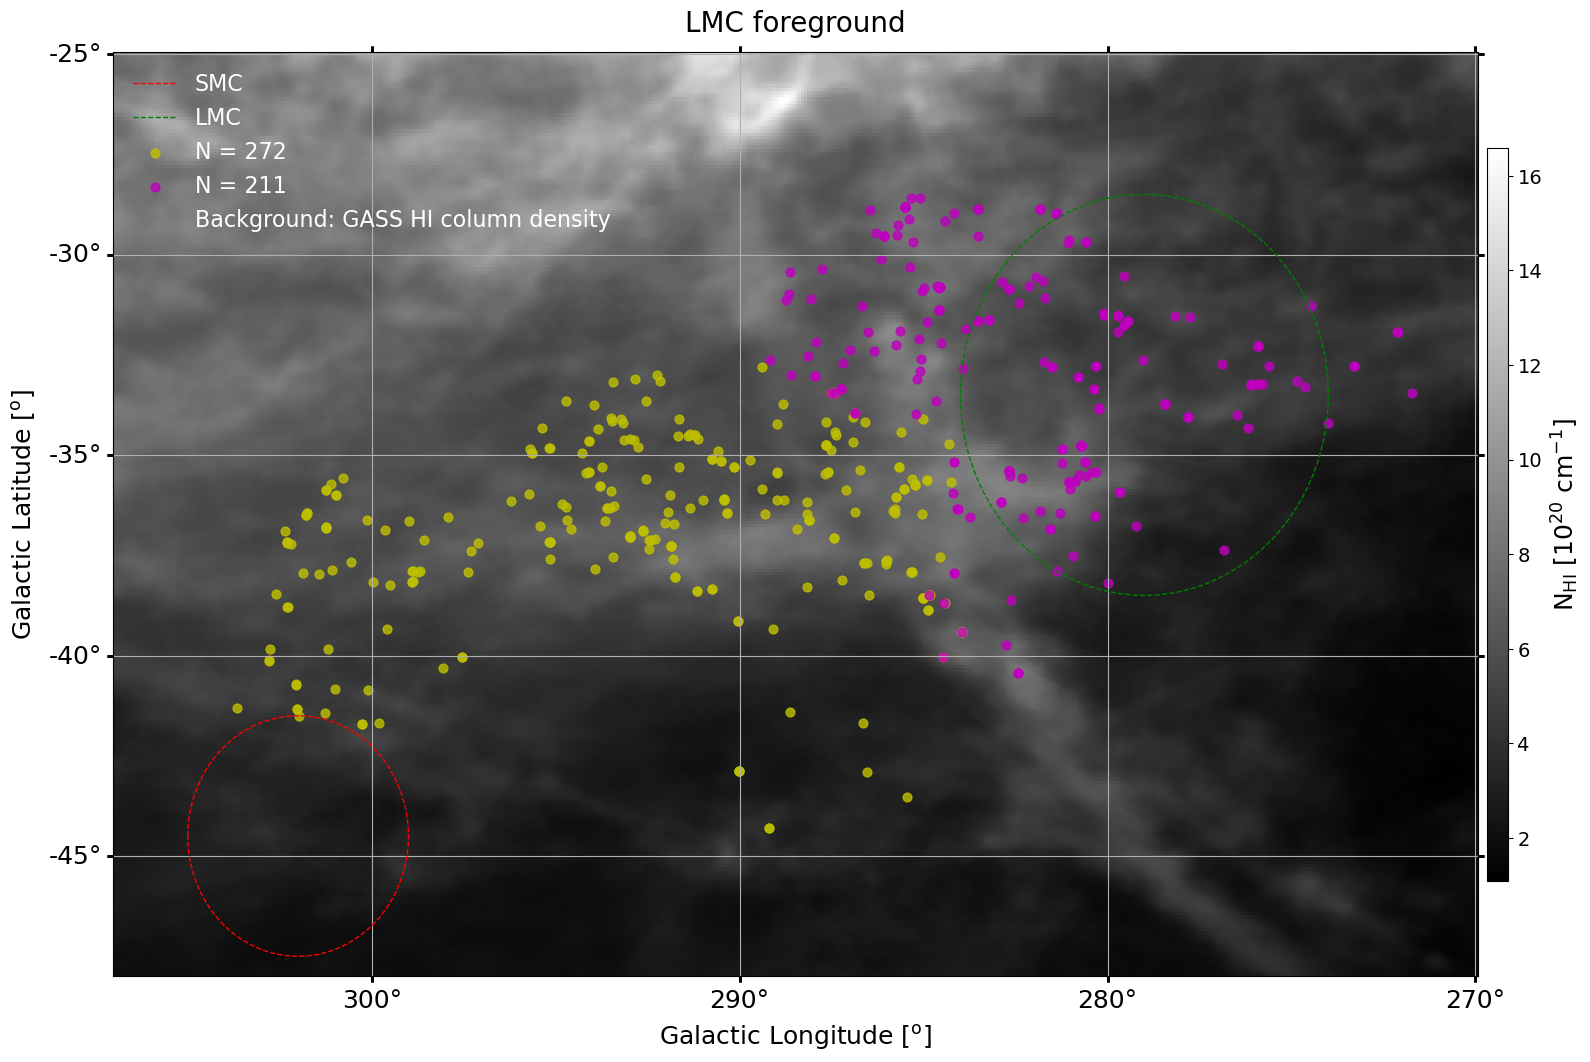

In [44]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection = hi_wcs)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = nhi_thin.min()
maxval = nhi_thin.max()

# im = ax.pcolormesh(HI_GLON, HI_GLAT, nhi_thin, cmap='gray', vmin=minval, vmax=maxval)
im = ax.pcolormesh(nhi_thin, cmap='gray', vmin=minval, vmax=maxval)

# Approximate locations of LMC, SMC
ax.plot(SMC_xcirc, SMC_ycirc, transform=ax.get_transform('galactic'), lw=1., color='r', ls='--', label='SMC')
ax.plot(LMC_xcirc, LMC_ycirc, transform=ax.get_transform('galactic'), lw=1., color='g', ls='--', label='LMC')

ax.scatter(src_gl_LMC, src_gb_LMC, s=40,
           transform=ax.get_transform('galactic'),
           marker='o', c='y', alpha=0.8,
           label=f'N = {n_abs_LMC_fg}')

ax.scatter(src_gl_bridge, src_gb_bridge, s=40,
           transform=ax.get_transform('galactic'),
           marker='o', c='m', alpha=0.8,
           label=f'N = {n_abs_bridge_fg}')


ploti, = plt.plot([], [], '', label=f"Background: GASS HI column density")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
# ax.invert_xaxis()

# ax.set_xlim(307., 270.)
# ax.set_ylim(-48., -25.)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$\mathrm{N_{HI}}$ [10$^{20}$ cm$^{-1}$]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"LMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

# SMC foreground

In [52]:
# For LMC only
# lat_range = [-48., -25.]
# lon_range = [270., 310.]

# glon_mc = np.arange(270., 310., 0.1)
# glat_mc = np.arange(-48., -25., 0.1)

# For SMC only
step = 0.1
glon_mc = np.arange(290., 315., step)
glat_mc = np.arange(-52., -40, step)

GLON, GLAT = np.meshgrid(glon_mc, glat_mc, indexing='ij')

# Read dust data

In [47]:
dustmap_file = 'SMCs_fg_dust_map_A0_LAL19.fits'
dmap, hdr = fits.getdata(dustmap_file, header=True)
print('Image shape: ', dmap.shape)

# Parse the WCS keywords in the primary HDU
wdust = WCS(hdr)

Image shape:  (250, 120, 200)


In [48]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  120                                                  
NAXIS3  =                  250                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                125.0 / Pixel coordinate of reference point            
CRPIX2  =                 60.0 / Pixel coordinate of reference point            
CRPIX3  =                100.0 / Pixel coordinate of reference point            
CDELT1  =   -0.099600000000023 / [deg] Coordinate increment at reference point  
CDELT2  =   -0.099166666666668 / [deg] Coordinate increment at reference point  
CDELT3  =               -4.9

In [56]:
nx, ny, nchan = dmap.shape
print(nx, ny, nchan)

250 120 200


In [61]:
# Distance separation
dd = 5. # pc

In [62]:
dust_map = np.sum(dmap, axis=2) * dd

In [63]:
dust_map.shape

(250, 120)

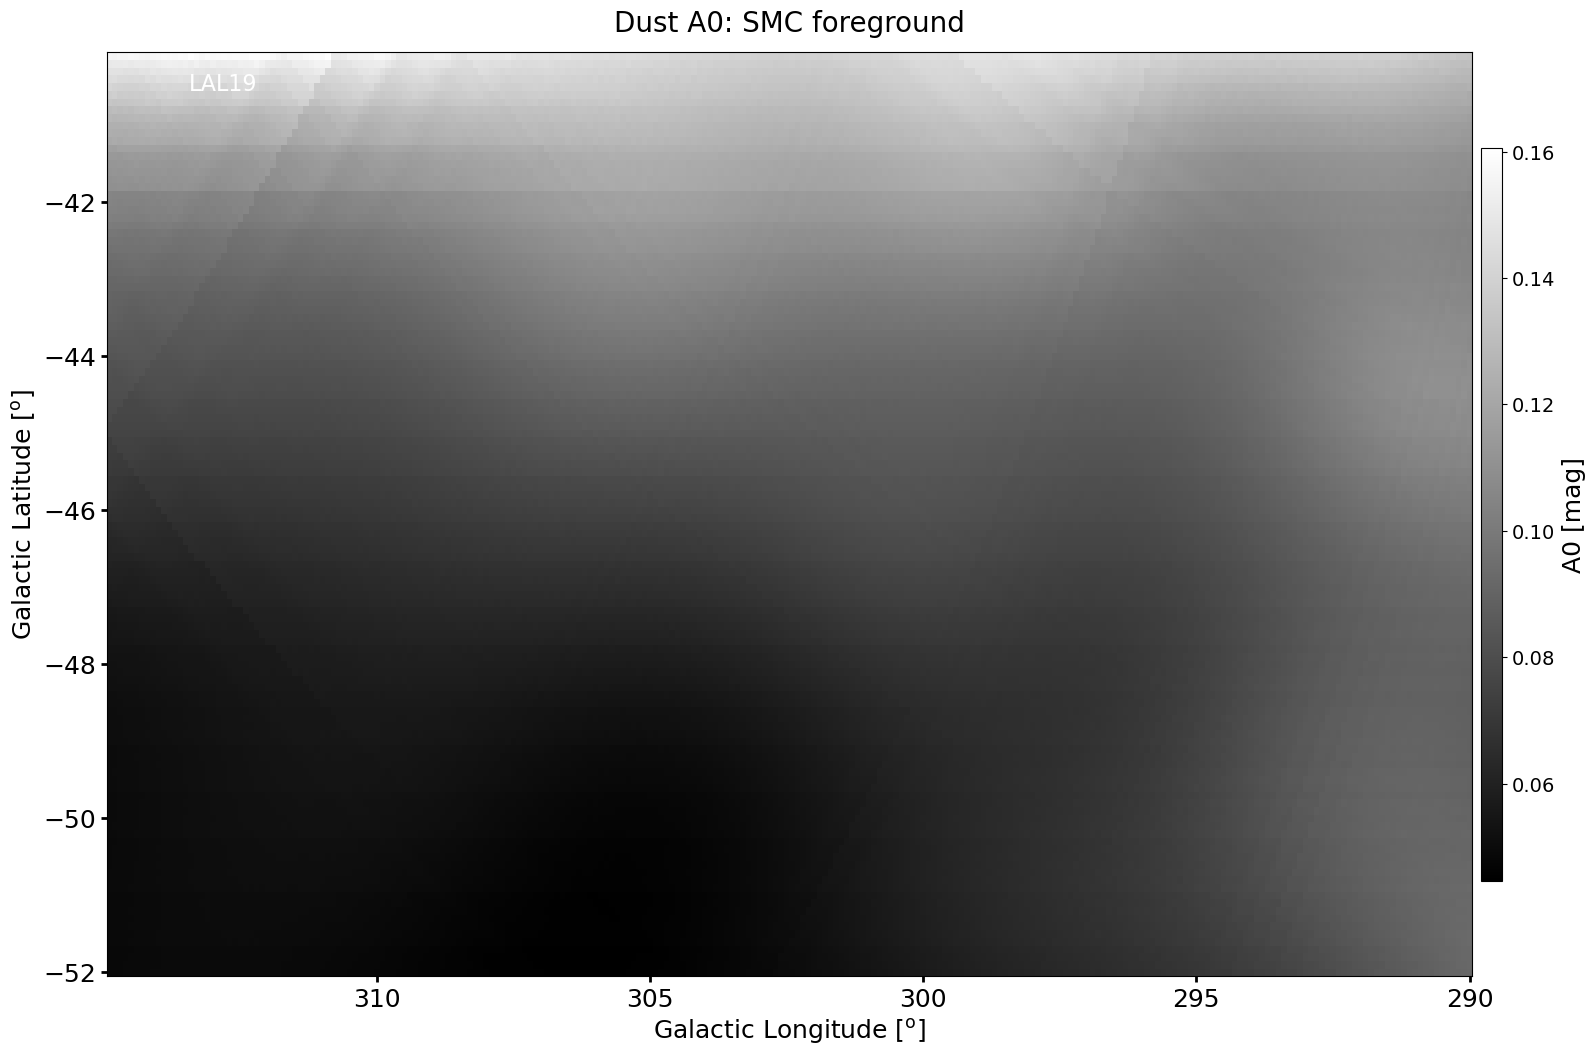

In [65]:
# Plot: Sources with Absorption (LMC foreground)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)

cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

# Display map
minval = dust_map.min()
maxval = dust_map.max()

# im = ax.imshow(0.018224*m0, cmap='gray')
# im = ax.pcolormesh(GL, GB, dust_img, cmap='gray', vmin=minval, vmax=maxval)
im = ax.pcolormesh(GLON, GLAT, dust_map, cmap='gray')

ploti, = plt.plot([], [], '', label="LAL19")
ploti.set_visible(False)


# Add axes labels
ax.set_xlabel(r"Galactic Longitude [$^\mathrm{o}$]", fontsize=18)
ax.set_ylabel(r"Galactic Latitude [$^\mathrm{o}$]", fontsize=18)

# ax.invert_yaxis()
ax.invert_xaxis()

# ax.set_ylim(-46.*u.deg,-27.*u.deg)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.015, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'A0 [mag]', rotation=90, labelpad=5., fontsize=18)
cbar.ax.tick_params(labelsize=14)

# plt.title(f"LMC foreground: Sources with Absorption (LMC foreground), N = {n_abs_fg} ({np.round(100.*n_abs_fg/n_sources, 1) } %)", fontsize=20)
plt.title(f"Dust A0: SMC foreground", fontsize=20, pad=15)

plt.legend(loc='upper left', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()

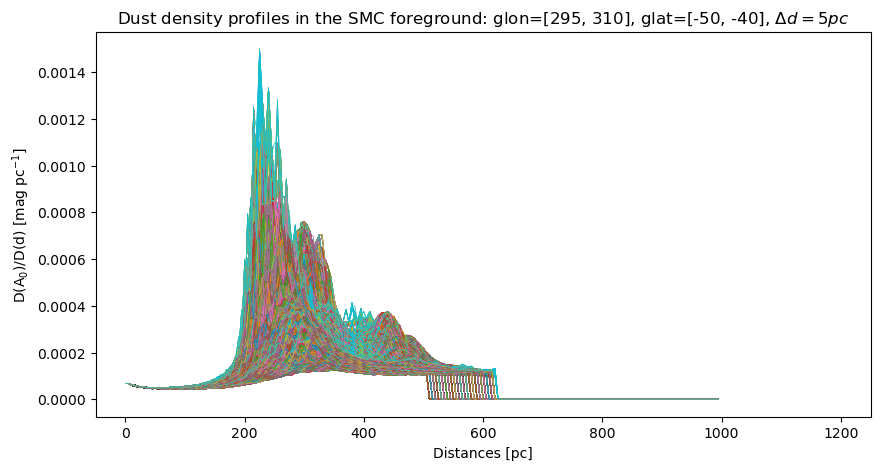

In [59]:
daxis = np.arange(0., nchan, 1.)*5.

plt.figure(figsize=(10, 5))

for (i,j) in np.ndindex(nx,ny):
    plt.plot(daxis, dmap[i,j,:], lw=0.5)

plt.xlim(-50, 1250)
plt.title('Dust density profiles in the SMC foreground: glon=[295, 310], glat=[-50, -40], $\Delta d = 5 pc$')
plt.xlabel('Distances [pc]')
plt.ylabel('D(A$_0$)/D(d) [mag pc$^{-1}$]')
plt.show()

In [75]:
print('End--')

End--
